In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rv_continuous

In [49]:
seed = 42
np.random.seed(seed)

# mixed device is good for bloch sphere plots
dev = qml.device('default.mixed', wires=1)

class sin_prob_dist(rv_continuous):
    def _pdf(self, theta):
        return 0.5 * np.sin(theta)
    
# Some unknown distribution
class cos_prob_dist(rv_continuous):
    def _pdf(self, theta):
        return 0.5 * np.cos(theta)
    
class band_prob_dist(rv_continuous):
    def _pdf(self, theta):
        center = np.pi /2
        width = np.pi / 100
        return np.exp(-((theta - center) ** 2) / (2 * width ** 2))
    
# Samples drawn from between 0 and pi
sin_sampler = sin_prob_dist(a=0, b=np.pi)
dist_sampler = cos_prob_dist(a=0, b=np.pi)
# dist_sampler = band_prob_dist(a=0, b=np.pi)

@qml.qnode(dev)
def haar_random_unitary():
    phi, omega = 2 * np.pi * np.random.uniform(size=2)
    theta = sin_sampler.rvs()
    qml.Rot(phi, theta, omega, wires=0)
    return qml.state()

@qml.qnode(dev)
def dist_random_unitary():
    phi, omega = 2 * np.pi * np.random.uniform(size=2)
    theta = dist_sampler.rvs()
    qml.Rot(phi, theta, omega, wires=0)
    return qml.state()

num_samples = 1000
dist_samples = [dist_random_unitary() for _ in range(num_samples)]

X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

def convert_to_bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    return [ax, ay, az]

distribution_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in dist_samples])

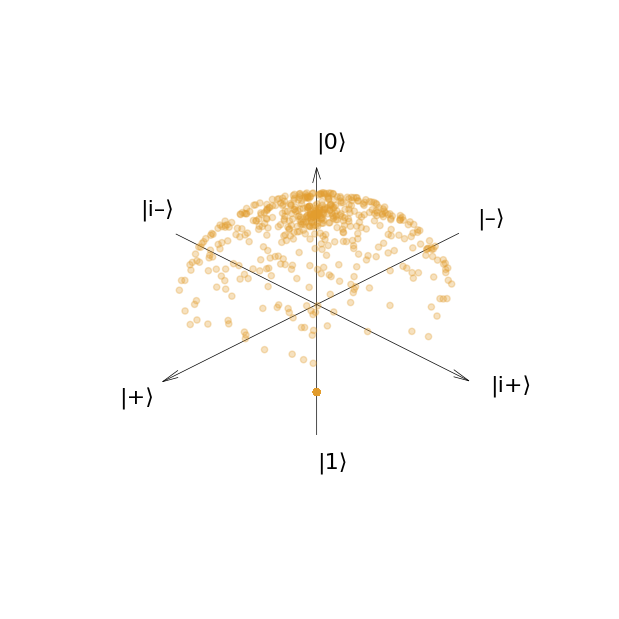

In [50]:
def plot_bloch_sphere(bloch_vectors):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    ax.grid(False)
    ax.set_axis_off()
    ax.view_init(30, 45)
    ax.dist = 7

    x, y, z = np.array([[-1.5,0,0], [0, -1.5, 0], [0, 0, -1.5]])
    u, v, w = np.array([[3,0,0], [0, 3, 0], [0,0,3]])
    ax.quiver(x, y, z, u, v, w, arrow_length_ratio=0.05, color="black", linewidth=0.5)

    ax.text(0, 0, 1.7, r"|0⟩", color="black", fontsize=16)
    ax.text(0, 0, -1.9, r"|1⟩", color="black", fontsize=16)
    ax.text(1.9, 0, 0, r"|+⟩", color="black", fontsize=16)
    ax.text(-1.7, 0, 0, r"|–⟩", color="black", fontsize=16)
    ax.text(0, 1.7, 0, r"|i+⟩", color="black", fontsize=16)
    ax.text(0,-1.9, 0, r"|i–⟩", color="black", fontsize=16)

    ax.scatter(bloch_vectors[:, 0], bloch_vectors[:, 1], bloch_vectors[:, 2], c="#e29d2e", alpha=0.3)
    
plot_bloch_sphere(distribution_bloch_vectors)

(1000, 2, 2) [[ 1.88711511e-17+1.87631122e-17j  2.00148320e-01+3.85768701e-01j]
 [-4.65773050e-17+2.95259106e-17j -8.71429836e-01+2.27449334e-01j]]
(1000, 3) [ 0.20014832 -0.3857687   0.87142984]


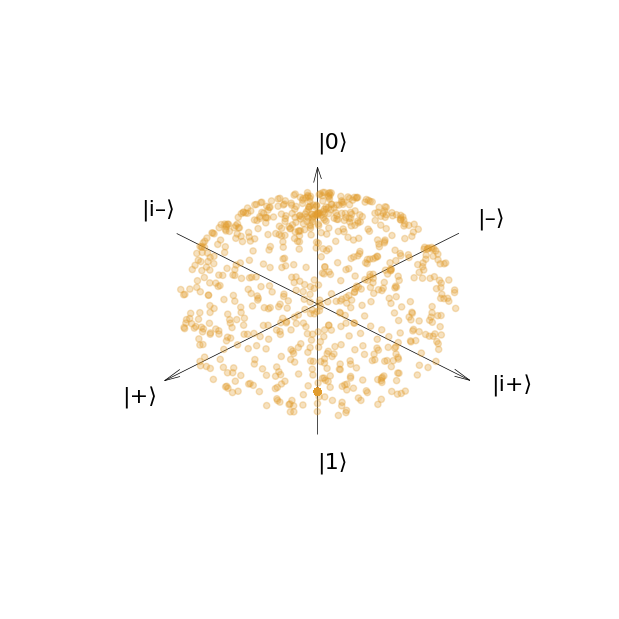

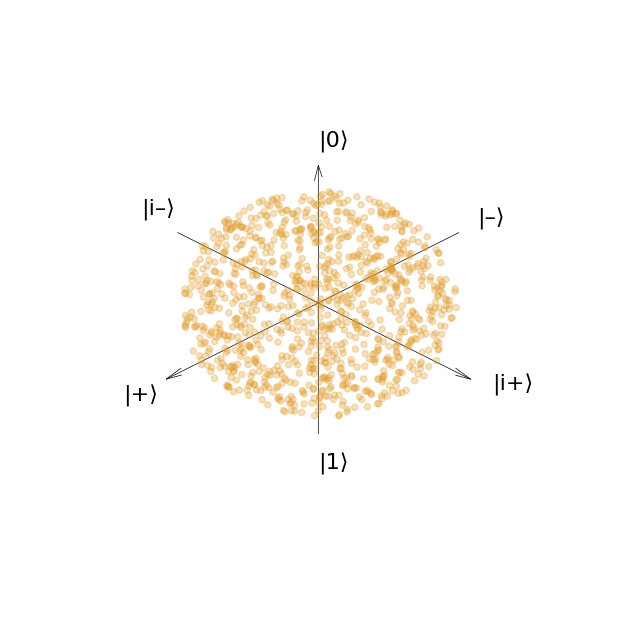

In [51]:
from scipy.stats import unitary_group

def haar_random_unitary(seed=None):
    if seed is not None:
        np.random.seed(seed)
    return unitary_group.rvs(2)

def scramble_state_vectors(state_vectors, seed):
    scrambled_vectors = []

    for i in range(num_samples):
        U = haar_random_unitary()
        
        scrambled_state = np.dot(U, state_vectors[i])
        scrambled_state /= np.linalg.norm(scrambled_state)
        scrambled_vectors.append(scrambled_state)

        # Half way point for Bloch visualization
        if i == num_samples//2:
            scrambled_bloch_states = np.array([convert_to_bloch_vector(s) for s in np.array(scrambled_vectors)])
            remaining_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in state_vectors[i-1:]])
            half_scrambled_states = np.concatenate((scrambled_bloch_states, remaining_bloch_vectors), axis=0)
            plot_bloch_sphere(half_scrambled_states)

        if seed is not None:
            if i % 4 == 0:
                seed += 1
    return np.array(scrambled_vectors)

scrambled_states = scramble_state_vectors(np.array(dist_samples), seed)
print(scrambled_states.shape, scrambled_states[0])
scrambled_bloch_states = np.array([convert_to_bloch_vector(s) for s in scrambled_states])
print(scrambled_bloch_states.shape, scrambled_bloch_states[0])
plot_bloch_sphere(scrambled_bloch_states)

## Denoising ## 

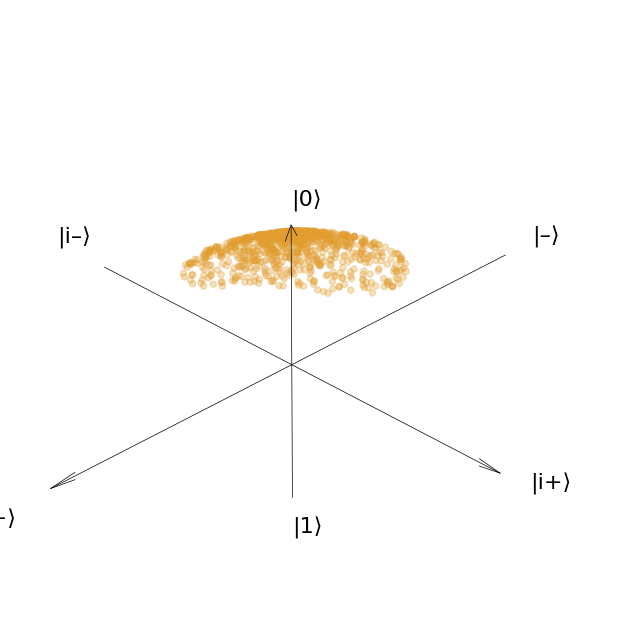

In [55]:
np.random.seed(seed)

def convert_to_state_vector(bloch_vector):
    bloch_vector = np.asarray(bloch_vector)
    if bloch_vector.shape != (3,):
        raise ValueError("Bloch vector must have shape (3,)")
    
    theta = bloch_vector[1]
    phi = bloch_vector[2]

    state_vector = np.array([
        np.cos(theta / 2),
        np.sin(theta / 2) * np.exp(1j * phi)
    ])
    
    return state_vector

@qml.qnode(dev)
def backward_circuit(state, params, n_layers):
    state = normalize_state(convert_to_state_vector(state))
    # state = [[1-0j, 0-0j], [0-0j, 1-0j]]
    # print("Sum of squares ", sum(np.absolute(state) ** 2))
    qml.QubitStateVector(state, wires=0)
    for l in range(n_layers):
        qml.RX(params[2*l], wires=0)
        qml.RY(params[2*l+1], wires=0)
    return qml.state()

def normalize_state(state):
    norm = np.linalg.norm(state)
    if norm == 0:
        raise ValueError("Norm of the state is zero, cannot normalize")
    return state / norm

# def normalize_complex_arr(a):
#     a_oo = a - a.real.min() - 1j*a.imag.min() # origin offsetted
#     return a_oo/np.abs(a_oo).max()

def backward_denoise(states, params, n_layers):
    denoised_states = []
    for idx, state in enumerate(states):
        denoised_state = backward_circuit(state, params, n_layers)
        denoised_state = normalize_state(denoised_state)
        if not np.allclose(np.sum(np.abs(denoised_state)**2), 1.0):
            raise ValueError(f"Sum of amplitudes-squared does not equal one for state index {idx}")
        denoised_states.append(denoised_state)
    return np.array(denoised_states)

n_layers = 100
params = np.random.uniform(0, np.pi, 2 * n_layers)

denoised_states = backward_denoise(scrambled_bloch_states, params, n_layers)
denoised_bloch_states = np.array([convert_to_bloch_vector(s) for s in denoised_states])
plot_bloch_sphere(denoised_bloch_states)


In [56]:
from scipy.optimize import minimize

# TODO: make different cost function following paper formula
# def cost(params, scrambled_states, n_layers):
#     target_states = np.array(dist_samples)

#     denoised_states = backward_denoise(scrambled_states, params, n_layers)

#     mse = np.mean(np.square(np.abs(denoised_states - target_states)))

#     return mse

def train(scrambled_states, n_layers):
    params = np.random.uniform(0, np.pi, 2 * n_layers)

    cost_fn = lambda x: cost(x, scrambled_states, n_layers)

    result = minimize(cost_fn, params, method='CG') # try other optimization methods

    optimized_params = result.x

    return optimized_params

n_layers = 5

optimized_params = train(scrambled_states, n_layers)
denoised_states = backward_denoise(scrambled_states, optimized_params, n_layers)
denoised_bloch_states = np.array([convert_to_bloch_vector(s) for s in denoised_states])

plot_bloch_sphere(denoised_bloch_states)


ValueError: Bloch vector must have shape (3,)